In [1]:
import pandas as pd
import os

import jax.numpy as jnp
from jax import random, vmap

!pip3 install numpyro
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

!pip3 install arviz
import arviz as az
import matplotlib.pyplot as plt
if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 5.1

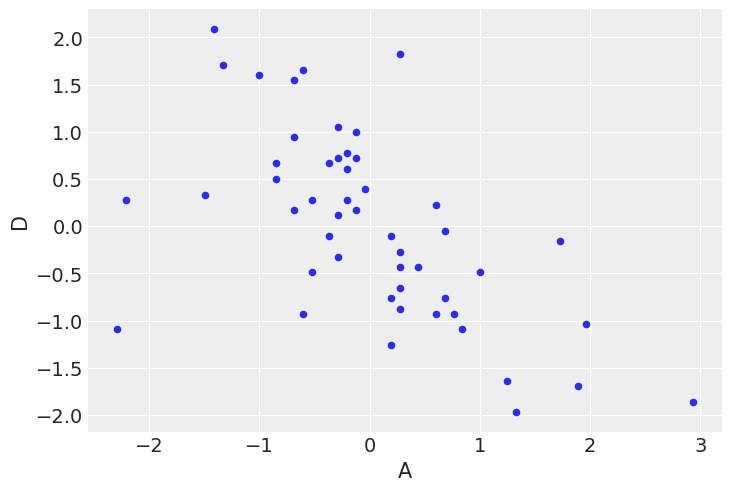

In [3]:
d = WaffleDivorce = pd.read_csv("https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/WaffleDivorce.csv", sep=";")
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())
d.plot.scatter(x='A', y='D')

## 5.2

In [ ]:
d.MedianAgeMarriage.std()

1.2436303013880823

## 5.3

In [12]:
def model(A, D=None):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma))

m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
p5_1 = svi.run(random.PRNGKey(0), 1000).params
p5_1

100%|██████████| 1000/1000 [00:01<00:00, 987.04it/s, init loss: 1840.6743, avg. loss [951-1000]: 108.1985]


{'auto_loc': DeviceArray([-0.6201674 ,  2.554333  , -0.14516519, -2.5743952 ,
              -2.8368134 , -1.1587346 , -5.0026293 ,  0.89146703,
              -1.4316791 ,  2.3324666 ,  0.50178105,  6.764002  ,
               0.13747476, -0.9105737 ,  1.086029  , -7.1324916 ,
               1.2760124 , -1.4248788 , -2.2474165 , -3.3703082 ,
              -3.8619556 , -0.90754896,  0.13207355,  1.7963436 ,
               4.2995267 ,  0.13194363, -0.05038695, -1.1724567 ,
              -1.699528  , -1.4296491 , -2.2795334 ,  0.89168674,
               2.5259058 , -1.1642257 ,  4.0759397 , -1.4252623 ,
              -2.566495  , -0.04996156, -4.7807245 , -0.67370933,
               1.4548881 ,  3.616999  ,  0.13191968, -1.6966047 ,
              -2.8427074 , -2.8373852 , -6.950431  ,  1.086006  ,
               0.13799548, -0.90772915, -3.372723  , -0.05142912,
              -5.2176013 ], dtype=float32)}

## 5.4

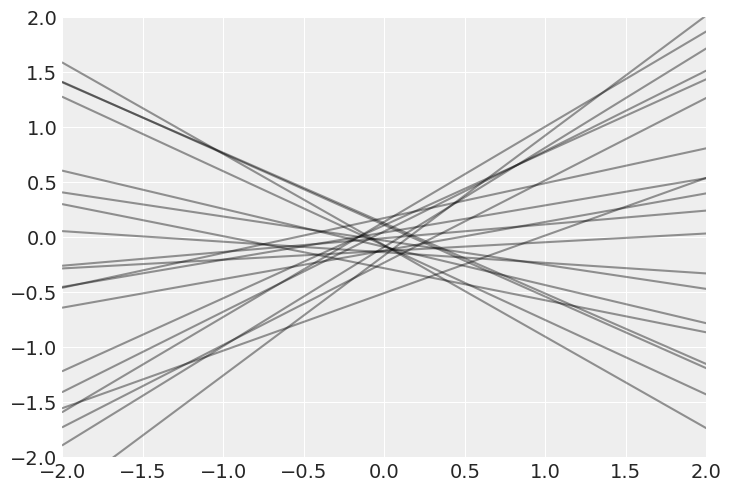

In [13]:
predictive = Predictive(m5_1.model, num_samples=1000)
prior_pred = predictive(random.PRNGKey(10), A=jnp.array([-2, 2]))
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)

In [6]:
prior_pred.keys()

dict_keys(['D', 'a', 'bA', 'mu', 'sigma'])

## 5.5

<ipython-input-19-cb2917df342c>:2: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1000,))


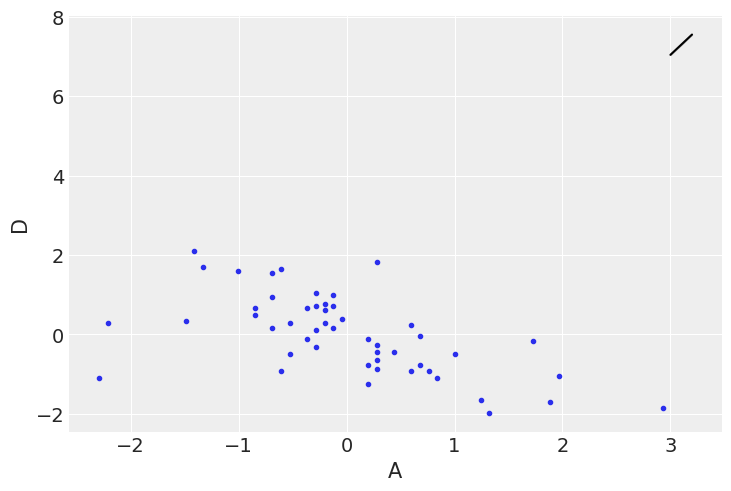

In [19]:
aseq = jnp.linspace(start=3, stop=3.2, num=30)
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1000,))
postpred = Predictive(m5_1.model, post )(random.PRNGKey(1), A=aseq)
mu = postpred['mu']
mumean = jnp.mean(mu, 0)
mupi = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)

az.plot_pair(d[["A", "D"]].to_dict(orient="list"))
plt.plot(aseq, mumean, "k")
plt.fill_between(aseq, mupi[0], mupi[1], color="k", alpha=0.2)
plt.show()

In [ ]:
post['a']

In [18]:
postpred

{'mu': DeviceArray([[7.0428314, 7.0604477, 7.078064 , ..., 7.5184655, 7.5360823,
               7.553698 ],
              [7.0428314, 7.0604477, 7.078064 , ..., 7.5184655, 7.5360823,
               7.553698 ],
              [7.0428314, 7.0604477, 7.078064 , ..., 7.5184655, 7.5360823,
               7.553698 ],
              ...,
              [7.0428314, 7.0604477, 7.078064 , ..., 7.5184655, 7.5360823,
               7.553698 ],
              [7.0428314, 7.0604477, 7.078064 , ..., 7.5184655, 7.5360823,
               7.553698 ],
              [7.0428314, 7.0604477, 7.078064 , ..., 7.5184655, 7.5360823,
               7.553698 ]], dtype=float32)}

## 5.6